In [2]:

import dagshub
import mlflow
dagshub.init(repo_owner='lkata22', repo_name='walmart-sales-forecasting-final-project', mlflow=True)


Initialized MLflow to track repo "lkata22/walmart-sales-forecasting-final-project"

Repository lkata22/walmart-sales-forecasting-final-project initialized!

In [3]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/ML_FInal_Project

Mounted at /content/drive
/content/drive/MyDrive/ML_FInal_Project


In [6]:
# Walmart Sales Forecasting - N-BEATS Model Experiment
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Deep Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# MLflow imports
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient
import pickle
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, forecast_size, theta_size, basis_function, layers, layer_size):
        super(NBeatsBlock, self).__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, layer_size))
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        self.theta_layer = nn.Linear(layer_size, theta_size)

        # Pass correct backcast and forecast lengths to each basis
        if basis_function == 'trend':
            self.basis = TrendBasis(input_size, forecast_size)
        elif basis_function == 'seasonality':
            self.basis = SeasonalityBasis(input_size, forecast_size)
        else:
            self.basis = GenericBasis(input_size, forecast_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        theta = self.theta_layer(x)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

class TrendBasis(nn.Module):
    """Trend basis function for interpretable forecasting"""
    def __init__(self, backcast_length, forecast_length):
        super(TrendBasis, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        # Polynomial basis
        self.polynomial_size = 3  # degree 2 polynomial

    def forward(self, theta):
        batch_size = theta.shape[0]

        # Split theta for backcast and forecast
        backcast_theta = theta[:, :self.polynomial_size]
        forecast_theta = theta[:, self.polynomial_size:2*self.polynomial_size]

        # Create time vectors
        backcast_time = torch.arange(0, self.backcast_length, dtype=torch.float32, device=theta.device)
        forecast_time = torch.arange(self.backcast_length,
                                   self.backcast_length + self.forecast_length,
                                   dtype=torch.float32, device=theta.device)

        # Normalize time
        backcast_time = 2 * (backcast_time - backcast_time.mean()) / (backcast_time.max() - backcast_time.min())
        forecast_time = 2 * (forecast_time - forecast_time.mean()) / (forecast_time.max() - forecast_time.min())

        # Create polynomial basis
        backcast_basis = torch.stack([
            torch.ones_like(backcast_time),
            backcast_time,
            backcast_time ** 2
        ], dim=1)  # [time, degree]

        forecast_basis = torch.stack([
            torch.ones_like(forecast_time),
            forecast_time,
            forecast_time ** 2
        ], dim=1)  # [time, degree]

        # Compute outputs
        backcast = torch.matmul(backcast_basis, backcast_theta.T).T  # [batch, time]
        forecast = torch.matmul(forecast_basis, forecast_theta.T).T  # [batch, time]

        return backcast, forecast

class SeasonalityBasis(nn.Module):
    """Seasonality basis function for interpretable forecasting"""
    def __init__(self, backcast_length, forecast_length):
        super(SeasonalityBasis, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        # Harmonics for seasonality
        self.harmonics = 10

    def forward(self, theta):
        batch_size = theta.shape[0]

        # Split theta for backcast and forecast
        backcast_theta = theta[:, :2*self.harmonics]
        forecast_theta = theta[:, 2*self.harmonics:4*self.harmonics]

        # Create time vectors
        backcast_time = torch.arange(0, self.backcast_length, dtype=torch.float32, device=theta.device)
        forecast_time = torch.arange(self.backcast_length,
                                   self.backcast_length + self.forecast_length,
                                   dtype=torch.float32, device=theta.device)

        # Create harmonic basis
        backcast_basis = []
        forecast_basis = []

        for i in range(1, self.harmonics + 1):
            backcast_basis.extend([
                torch.cos(2 * np.pi * i * backcast_time / self.backcast_length),
                torch.sin(2 * np.pi * i * backcast_time / self.backcast_length)
            ])
            forecast_basis.extend([
                torch.cos(2 * np.pi * i * forecast_time / self.backcast_length),
                torch.sin(2 * np.pi * i * forecast_time / self.backcast_length)
            ])

        backcast_basis = torch.stack(backcast_basis, dim=1)  # [time, harmonics*2]
        forecast_basis = torch.stack(forecast_basis, dim=1)  # [time, harmonics*2]

        # Compute outputs
        backcast = torch.matmul(backcast_basis, backcast_theta.T).T  # [batch, time]
        forecast = torch.matmul(forecast_basis, forecast_theta.T).T  # [batch, time]

        return backcast, forecast

class GenericBasis(nn.Module):
    """Generic basis function for flexible forecasting"""
    def __init__(self, backcast_length, forecast_length):
        super(GenericBasis, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        # Linear layers for basis functions
        self.backcast_basis = nn.Linear(backcast_length, backcast_length)
        self.forecast_basis = nn.Linear(forecast_length, forecast_length)

    def forward(self, theta):
        # Split theta for backcast and forecast
        backcast_theta = theta[:, :self.backcast_length]
        forecast_theta = theta[:, self.backcast_length:]

        # Apply basis functions
        backcast = self.backcast_basis(backcast_theta)
        forecast = self.forecast_basis(forecast_theta)

        return backcast, forecast

class NBeatsStack(nn.Module):
    def __init__(self, input_size, forecast_size, basis_function, num_blocks, layers, layer_size):
        super(NBeatsStack, self).__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size

        if basis_function == 'trend':
            # 3 thetas for backcast + 3 for forecast
            theta_size = 6
        elif basis_function == 'seasonality':
            # 20 for backcast + 20 for forecast (10 harmonics * 2, for each)
            theta_size = 40
        else:
            # generic: input_size + forecast_size
            theta_size = input_size + forecast_size

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(
                NBeatsBlock(input_size, forecast_size, theta_size, basis_function, layers, layer_size)
            )

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.shape[0], self.forecast_size, device=x.device)
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

class NBeatsModel(nn.Module):
    def __init__(self, input_size, forecast_size, num_stacks=2, num_blocks=3, layers=4, layer_size=512):
        super(NBeatsModel, self).__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size

        self.stacks = nn.ModuleList()
        # Trend stack
        self.stacks.append(
            NBeatsStack(input_size, forecast_size, 'trend', num_blocks, layers, layer_size)
        )
        # Seasonality stack
        self.stacks.append(
            NBeatsStack(input_size, forecast_size, 'seasonality', num_blocks, layers, layer_size)
        )
        # Generic stacks
        for _ in range(num_stacks - 2):
            self.stacks.append(
                NBeatsStack(input_size, forecast_size, 'generic', num_blocks, layers, layer_size)
            )

    def forward(self, x):
        forecast = torch.zeros(x.shape[0], self.forecast_size, device=x.device)
        for stack in self.stacks:
            forecast = forecast + stack(x)
        return forecast

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Always returns float32 tensors
        return (
            torch.from_numpy(self.sequences[idx]).float(),
            torch.from_numpy(self.targets[idx]).float(),
        )



class WalmartNBeatsForecaster:
    """N-BEATS model for Walmart sales forecasting with MLflow logging"""

    def __init__(self, experiment_name="NBEATS_Training"):
        self.model = None
        self.scaler = None
        self.lookback_window = 52  # 1 year of weekly data
        self.forecast_window = 8   # 2 months ahead
        self.experiment_name = experiment_name
        self.device = device
        self._logged_params = set()

    def log_param_once(self, key, value):
        """Log parameter only once to avoid duplicates"""
        if key not in self._logged_params:
            mlflow.log_param(key, value)
            self._logged_params.add(key)

    def load_and_prepare_data(self, data_path="data"):
        """Load and prepare the Walmart dataset"""
        try:
            # Load datasets
            train_df = pd.read_csv(f"{data_path}/train.csv")
            features_df = pd.read_csv(f"{data_path}/features.csv")
            stores_df = pd.read_csv(f"{data_path}/stores.csv")

            print(f"Loaded datasets - Train: {train_df.shape}, Features: {features_df.shape}, Stores: {stores_df.shape}")

            # Log dataset info
            self.log_param_once("train_shape", train_df.shape)
            self.log_param_once("features_shape", features_df.shape)
            self.log_param_once("stores_shape", stores_df.shape)

            # Merge datasets
            df = train_df.merge(features_df, on=['Store', 'Date'], how='inner')
            df = df.merge(stores_df, on=['Store'], how='inner')

            # Handle duplicate columns
            if 'IsHoliday_y' in df.columns:
                df.drop(['IsHoliday_y'], axis=1, inplace=True)
                df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

            # Convert date and filter positive sales
            df['Date'] = pd.to_datetime(df['Date'])
            df = df[df['Weekly_Sales'] > 0]

            # Log merged data info
            self.log_param_once("merged_shape", df.shape)
            self.log_param_once("date_range", f"{df['Date'].min()} to {df['Date'].max()}")

            print(f"Merged dataset shape: {df.shape}")
            print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

            return df

        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def create_time_series_data(self, df):
        """Create time series data for each store-department combination"""
        print("Creating time series data...")

        # Sort by store, department, and date
        df = df.sort_values(['Store', 'Dept', 'Date'])

        # Create time series for each store-department combination
        time_series_data = []
        store_dept_info = []

        for (store, dept), group in df.groupby(['Store', 'Dept']):
            # Ensure we have enough data points
            if len(group) >= self.lookback_window + self.forecast_window:
                # Get time series
                sales_series = group['Weekly_Sales'].values

                # Store metadata
                store_info = {
                    'Store': store,
                    'Dept': dept,
                    'Size': group['Size'].iloc[0],
                    'Type': group['Type'].iloc[0],
                    'series_length': len(sales_series),
                    'mean_sales': sales_series.mean(),
                    'std_sales': sales_series.std()
                }

                time_series_data.append(sales_series)
                store_dept_info.append(store_info)

        # Log time series info
        self.log_param_once("num_time_series", len(time_series_data))
        self.log_param_once("avg_series_length", np.mean([len(ts) for ts in time_series_data]))
        self.log_param_once("min_series_length", np.min([len(ts) for ts in time_series_data]))
        self.log_param_once("max_series_length", np.max([len(ts) for ts in time_series_data]))

        print(f"Created {len(time_series_data)} time series")
        print(f"Average series length: {np.mean([len(ts) for ts in time_series_data]):.1f}")

        return time_series_data, store_dept_info

    def prepare_sequences(self, time_series_data, test_size=0.2):
        """Prepare sequences for training"""
        print("Preparing sequences...")

        # Combine all time series data
        all_sequences = []
        all_targets = []

        for ts in time_series_data:
            # Create sequences from each time series
            for i in range(len(ts) - self.lookback_window - self.forecast_window + 1):
                seq = ts[i:i + self.lookback_window]
                target = ts[i + self.lookback_window:i + self.lookback_window + self.forecast_window]
                all_sequences.append(seq)
                all_targets.append(target)

        # Convert to numpy arrays
        all_sequences = np.array(all_sequences)
        all_targets = np.array(all_targets)

        # Log sequence info
        self.log_param_once("total_sequences", len(all_sequences))
        self.log_param_once("lookback_window", self.lookback_window)
        self.log_param_once("forecast_window", self.forecast_window)

        print(f"Total sequences: {len(all_sequences)}")
        print(f"Sequence shape: {all_sequences.shape}")
        print(f"Target shape: {all_targets.shape}")

        # Split into train and test
        train_sequences, test_sequences, train_targets, test_targets = train_test_split(
            all_sequences, all_targets, test_size=test_size, random_state=42, shuffle=False
        )

        # Scale the data
        self.scaler = StandardScaler()

        # Fit scaler on training data
        train_sequences_scaled = self.scaler.fit_transform(
            train_sequences.reshape(-1, 1)
        ).reshape(train_sequences.shape)

        train_targets_scaled = self.scaler.transform(
            train_targets.reshape(-1, 1)
        ).reshape(train_targets.shape)

        # Transform test data
        test_sequences_scaled = self.scaler.transform(
            test_sequences.reshape(-1, 1)
        ).reshape(test_sequences.shape)

        test_targets_scaled = self.scaler.transform(
            test_targets.reshape(-1, 1)
        ).reshape(test_targets.shape)

        # Log scaling info
        self.log_param_once("scaler_mean", self.scaler.mean_[0])
        self.log_param_once("scaler_std", self.scaler.scale_[0])
        self.log_param_once("train_sequences", len(train_sequences_scaled))
        self.log_param_once("test_sequences", len(test_sequences_scaled))

        return (train_sequences_scaled, test_sequences_scaled,
                train_targets_scaled, test_targets_scaled)

    def create_data_loaders(self, train_sequences, test_sequences, train_targets, test_targets, batch_size=32):
        """Create data loaders for training"""

        # Create datasets
        train_dataset = TimeSeriesDataset(
            list(zip(train_sequences, train_targets)), self.lookback_window, self.forecast_window
        )
        test_dataset = TimeSeriesDataset(
            list(zip(test_sequences, test_targets)), self.lookback_window, self.forecast_window
        )

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.log_param_once("batch_size", batch_size)
        self.log_param_once("train_batches", len(train_loader))
        self.log_param_once("test_batches", len(test_loader))

        return train_loader, test_loader

    def train_model(self, train_sequences, test_sequences, train_targets, test_targets,
                   num_epochs=100, learning_rate=0.001, batch_size=32):
        """Train the N-BEATS model"""

        # Log training parameters
        self.log_param_once("num_epochs", num_epochs)
        self.log_param_once("learning_rate", learning_rate)
        self.log_param_once("batch_size", batch_size)
        self.log_param_once("device", str(self.device))

        # Create model
        self.model = NBeatsModel(
            input_size=self.lookback_window,
            forecast_size=self.forecast_window,
            num_stacks=2,
            num_blocks=3,
            layers=4,
            layer_size=512
        ).to(self.device)

        # Log model parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        self.log_param_once("total_parameters", total_params)
        self.log_param_once("trainable_parameters", trainable_params)

        print(f"Model created with {total_params:,} parameters")

        # Create simple datasets
        train_dataset = TimeSeriesDataset(train_sequences, train_targets)
        test_dataset = TimeSeriesDataset(test_sequences, test_targets)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        print("Starting training...")

        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0.0

            for batch_idx, (sequences, targets) in enumerate(train_loader):
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(sequences)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for sequences, targets in test_loader:
                    sequences = sequences.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(sequences)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            # Calculate average losses
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Scheduler step
            scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_nbeats_model.pth')
            else:
                patience_counter += 1

            # Log metrics every 10 epochs
            if (epoch + 1) % 10 == 0:
                mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
                mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
                mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

                print(f"Epoch {epoch+1}/{num_epochs} - "
                      f"Train Loss: {avg_train_loss:.6f}, "
                      f"Val Loss: {avg_val_loss:.6f}, "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")

            # Early stopping
            if patience_counter >= 20:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model
        self.model.load_state_dict(torch.load('best_nbeats_model.pth'))

        # Log final metrics
        mlflow.log_metric("best_val_loss", best_val_loss)
        mlflow.log_metric("epochs_trained", epoch + 1)

        print(f"Training completed! Best validation loss: {best_val_loss:.6f}")

        return train_losses, val_losses

    def evaluate_model(self, test_sequences, test_targets):
        """Evaluate the trained model"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        self.model.eval()
        all_predictions = []
        all_targets = []

        # Create test loader
        test_dataset = TimeSeriesDataset(test_sequences, test_targets)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(sequences)

                # Move to CPU and convert to numpy
                outputs_np = outputs.cpu().numpy()
                targets_np = targets.cpu().numpy()

                all_predictions.extend(outputs_np)
                all_targets.extend(targets_np)

        # Convert to numpy arrays
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)

        # Inverse scale predictions and targets
        predictions_unscaled = self.scaler.inverse_transform(
            all_predictions.reshape(-1, 1)
        ).reshape(all_predictions.shape)

        targets_unscaled = self.scaler.inverse_transform(
            all_targets.reshape(-1, 1)
        ).reshape(all_targets.shape)

        # Calculate metrics
        mae = mean_absolute_error(targets_unscaled.flatten(), predictions_unscaled.flatten())
        rmse = np.sqrt(mean_squared_error(targets_unscaled.flatten(), predictions_unscaled.flatten()))
        r2 = r2_score(targets_unscaled.flatten(), predictions_unscaled.flatten())

        # Log metrics
        mlflow.log_metric("test_mae", mae)
        mlflow.log_metric("test_rmse", rmse)
        mlflow.log_metric("test_r2", r2)

        print(f"Test Metrics:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.4f}")

        return predictions_unscaled, targets_unscaled, mae, rmse, r2

    def plot_results(self, predictions, targets, train_losses, val_losses):
        """Plot training results and predictions"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Training losses
        axes[0, 0].plot(train_losses, label='Train Loss')
        axes[0, 0].plot(val_losses, label='Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Predictions vs Actual (sample)
        sample_idx = np.random.choice(len(predictions), min(100, len(predictions)), replace=False)
        sample_pred = predictions[sample_idx].flatten()
        sample_true = targets[sample_idx].flatten()

        axes[0, 1].scatter(sample_true, sample_pred, alpha=0.5)
        axes[0, 1].plot([sample_true.min(), sample_true.max()],
                       [sample_true.min(), sample_true.max()], 'r--', lw=2)
        axes[0, 1].set_xlabel('Actual Sales')
        axes[0, 1].set_ylabel('Predicted Sales')
        axes[0, 1].set_title('Predictions vs Actual (Sample)')
        axes[0, 1].grid(True)

        # 3. Residuals
        residuals = (sample_true - sample_pred)
        axes[1, 0].scatter(sample_pred, residuals, alpha=0.5)
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].set_xlabel('Predicted Sales')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residual Plot')
        axes[1, 0].grid(True)

        # 4. Time series example
        example_idx = 0
        time_points = range(len(predictions[example_idx]))
        axes[1, 1].plot(time_points, targets[example_idx], label='Actual', marker='o')
        axes[1, 1].plot(time_points, predictions[example_idx], label='Predicted', marker='s')
        axes[1, 1].set_xlabel('Time Steps')
        axes[1, 1].set_ylabel('Sales')
        axes[1, 1].set_title('Example Forecast')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()

        # Save plot
        plot_path = "nbeats_results.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(plot_path)
        plt.show()

    def save_model(self, model_name="nbeats_walmart_model"):
      """Save model and scaler to MLflow"""
      assert self.model is not None, "Train the model first!"
      # Save model to disk
      model_path = f"{model_name}.pth"
      scaler_path = f"{model_name}_scaler.pkl"
      torch.save(self.model.state_dict(), model_path)
      with open(scaler_path, "wb") as f:
          pickle.dump(self.scaler, f)
      # Log model and scaler as MLflow artifacts
      mlflow.log_artifact(model_path)
      mlflow.log_artifact(scaler_path)
      print(f"Model and scaler saved & logged to MLflow.")


    def load_model(self, model_path, scaler_path):
      """Load model and scaler from disk"""
      self.model = NBeatsModel(
          input_size=self.lookback_window,
          forecast_size=self.forecast_window,
          num_stacks=2, num_blocks=3, layers=4, layer_size=512
      ).to(self.device)
      self.model.load_state_dict(torch.load(model_path, map_location=self.device))
      self.model.eval()
      with open(scaler_path, "rb") as f:
          self.scaler = pickle.load(f)
      print(f"Loaded model from {model_path} and scaler from {scaler_path}")


    def predict(self, input_sequences):
      """
      Predict on new sequences (expects shape [N, lookback_window])
      Returns predictions in unscaled (original sales) units.
      """
      assert self.model is not None and self.scaler is not None
      self.model.eval()
      # Scale input if not already
      if input_sequences.shape[1] == self.lookback_window:
          sequences_scaled = self.scaler.transform(input_sequences.reshape(-1,1)).reshape(input_sequences.shape)
      else:
          raise ValueError("Shape mismatch for input_sequences")
      inputs = torch.FloatTensor(sequences_scaled).to(self.device)
      with torch.no_grad():
          outputs = self.model(inputs).cpu().numpy()
      # Inverse transform predictions
      predictions = self.scaler.inverse_transform(outputs.reshape(-1,1)).reshape(outputs.shape)
      return predictions

Using device: cuda


Loaded datasets - Train: (421570, 5), Features: (8190, 12), Stores: (45, 3)
Merged dataset shape: (420212, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Creating time series data...
Created 2968 time series
Average series length: 139.7
Preparing sequences...
Total sequences: 239459
Sequence shape: (239459, 52)
Target shape: (239459, 8)
Model created with 4,961,418 parameters
Starting training...
Epoch 10/15 - Train Loss: 0.024412, Val Loss: 0.018327, LR: 0.001000
Training completed! Best validation loss: 0.016086
Test Metrics:
MAE: 1249.79
RMSE: 3038.62
R²: 0.9755


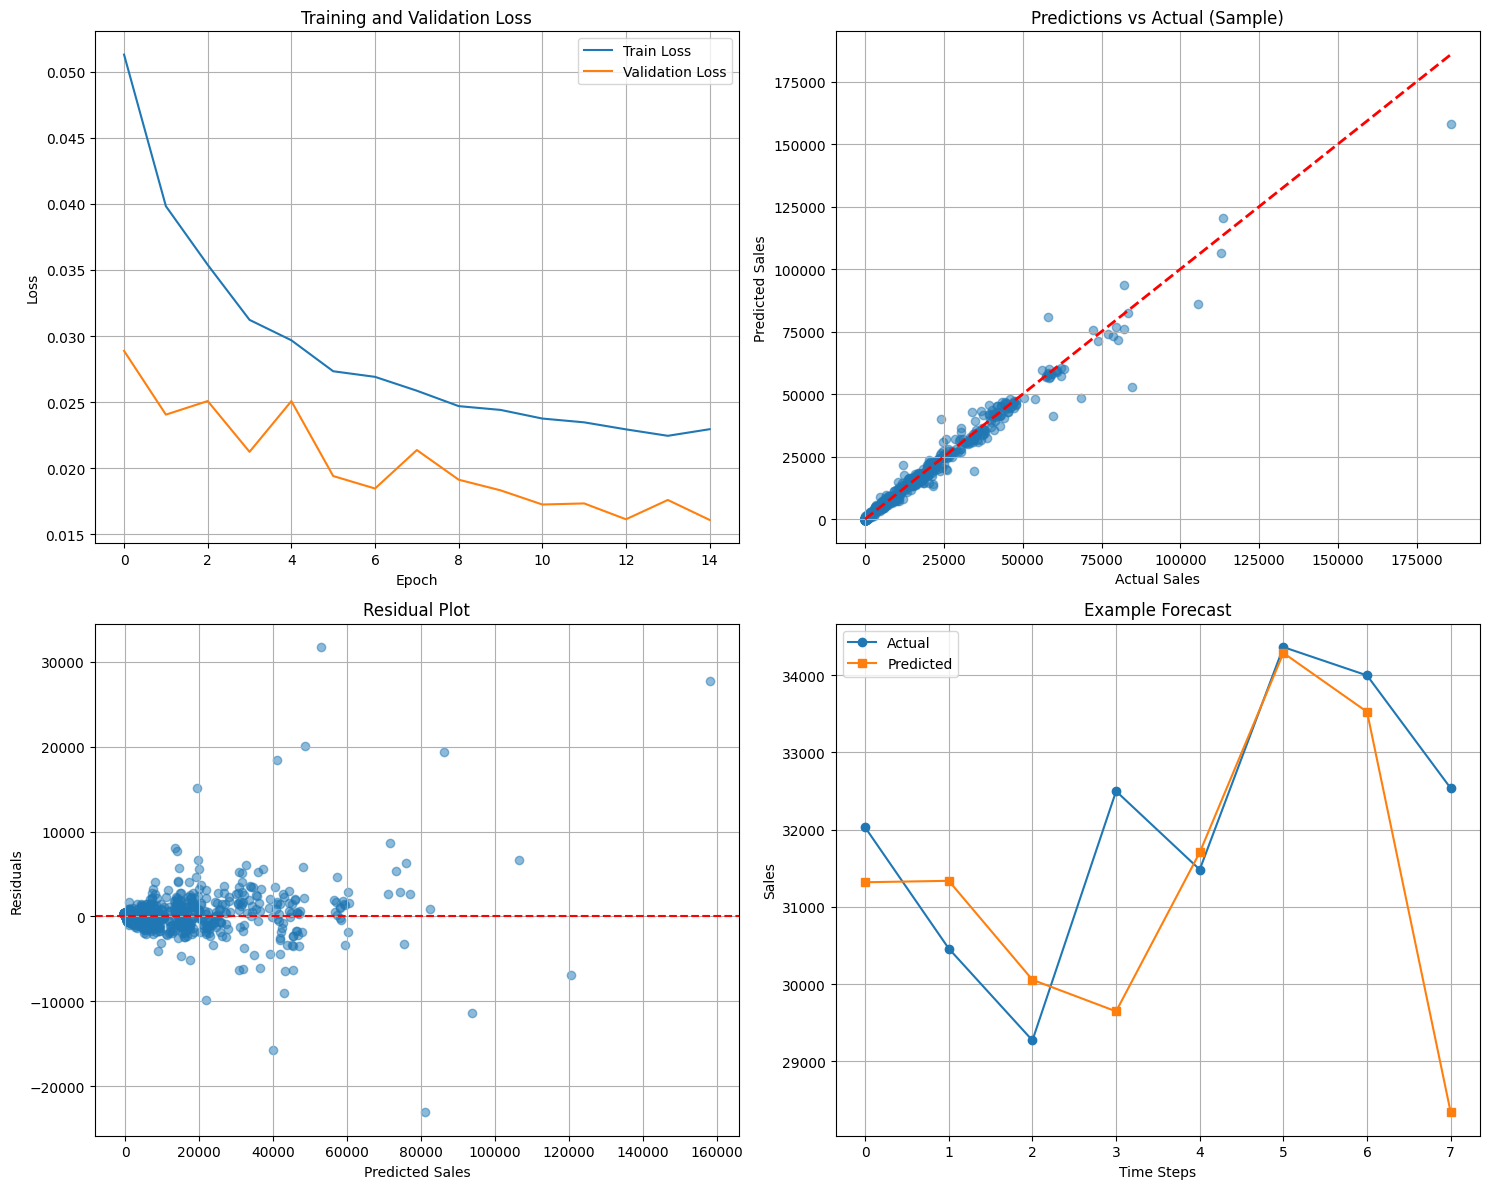

Model and scaler saved & logged to MLflow.
🏃 View run N-BEATS_Exp1 at: https://dagshub.com/lkata22/walmart-sales-forecasting-final-project.mlflow/#/experiments/9/runs/268a9d00be684bf9b65468924afca75c
🧪 View experiment at: https://dagshub.com/lkata22/walmart-sales-forecasting-final-project.mlflow/#/experiments/9


In [7]:
if __name__ == "__main__":
    # Start MLflow experiment
    mlflow.set_experiment("Walmart_NBEATS_Final")
    with mlflow.start_run(run_name="N-BEATS_Exp1"):
        forecaster = WalmartNBeatsForecaster()
        df = forecaster.load_and_prepare_data(data_path="data")
        time_series_data, store_dept_info = forecaster.create_time_series_data(df)
        train_seq, test_seq, train_tgt, test_tgt = forecaster.prepare_sequences(time_series_data)
        train_losses, val_losses = forecaster.train_model(train_seq, test_seq, train_tgt, test_tgt)
        preds, targets, mae, rmse, r2 = forecaster.evaluate_model(test_seq, test_tgt)
        forecaster.plot_results(preds, targets, train_losses, val_losses)
        forecaster.save_model("nbeats_walmart_model_v1")
